# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.19 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. State and Action Spaces

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the all agents looks like:', states)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]
The state for the all agents looks like: [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.         -6.65278625 -1.5        -0.          0.
   6.83172083  6.         -0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.         -6.4669857  -1.5         0.          0.
  -6.83172083  6.          0.          0.        ]]


### 3. The RL agent 

The agent can be found in the file ddpg_agent.py, which implements a standard DDPG with some adjustments that can be seen in the hyperparameters setup. 

Something important to mention is that during the first episodes we perform random actions instead of following the actor. The reason of this is to pretrain the model with highly explorative data in order to ensure a good training.

In [6]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from workspace_utils import active_session, keep_awake
import numpy as np
from collections import deque

def run_agent(agent, noise=True, n_episodes=1000, random_episodes=1000, max_t=1000, print_every=100):
    np.random.seed(agent.config.seed)
    scores = deque(maxlen=print_every)
    mean_score= []
    for i_episode in keep_awake(range(1, n_episodes+1)):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
#         agent.reset()
        score = np.zeros(2)
        for t in range(max_t):
            if i_episode < random_episodes:
                actions = 2*(np.random.rand(2,2)-0.5)
            else:
                actions = agent.act(states, add_noise=noise)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished            
            
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
#             if sum(rewards)>0.0001:
#                 print('\nI hit the ball! {:.2f}'. format(max(rewards)))
            if np.any(dones):
                break 
        scores.append(max(score))
        mean_score.append(max(score))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)), end="")
        agent.save(prefix=agent.alg+'_checkpoint')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))
        if np.mean(scores) > 0.5:
            print('\rProblem solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores)))
            agent.save(prefix=agent.alg+'_model')
            return mean_score
    return mean_score

def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### 4. Set up agent hyperparameters

The default hyper parameters are set in the following config. In this case epsilon referes to the scale and decay rate of the OU noise.

In [8]:
from utilities import DictX

def default_config():
    return DictX({'n_agents': 2, 'batch_size': 128, 'buffer_size': int(1e6), 'learn_every': 1, 'tau': 1e-3, \
            'gamma': 0.99, 'lr_actor': 1e-4, 'lr_critic': 1e-4, 'limit_gradients': True, 'seed': 0, \
            'bn_active': False, 'first_layer_size': 128, 'second_layer_size': 128, 'dropout_rate': 0.0, \
            'epsilon_start': 0.2, 'epsilon_decay': 0.999, 'epsilon_min': 0.001, 'sigma': 0.5, \
            'path': 'trained_models/', 'alpha': 0.6,'beta': 0.4,'beta_step': 0.002})

### 5. Train the agent and visualize reward

Episode 100	Average Score: 0.03
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.02
Episode 400	Average Score: 0.03
Episode 500	Average Score: 0.02
Episode 600	Average Score: 0.03
Episode 700	Average Score: 0.06
Episode 800	Average Score: 0.09
Episode 900	Average Score: 0.10
Episode 1000	Average Score: 0.12
Episode 1100	Average Score: 0.19
Problem solved in 1143 episodes!	Average Score: 0.52


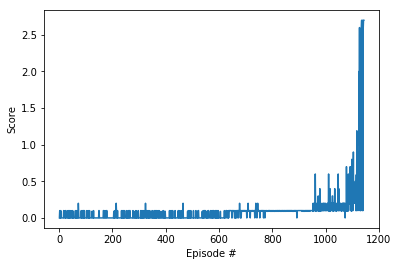

In [11]:
from ddpg_agent import DDPG
            
config = default_config()
config.batch_size = 1024
config.bn_active = True
config.epsilon_decay = 0.999
config.epsilon_start = 0.2
ddpg = DDPG(state_size, action_size, config)
scores = run_agent(ddpg, n_episodes=5000, random_episodes = 500)
plot_scores(scores)

### 6. Future Work
As a future work it could be interesting to try a natural extension of DDPG which would be the Twin Delayed DDPG (TD3) or the Multiple Agents DDPG (MADDPG)